In [1]:
import pandas as pd
from bertopic import BERTopic
from bertopic.representation import KeyBERTInspired
from umap import UMAP
import plotly.express as px
import itertools
import rapidfuzz
import numpy as np
from scipy.stats import pointbiserialr
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer
import spacy
import torch
import os
from wordcloud import WordCloud

from cuml import UMAP as cumlUMAP


# DISCLAIMER

Notebook under construction


In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 10000)

# 1. Analiza DF niezaanotowanego


In [3]:
df_sejm = pd.read_pickle('./bertopic_data/sejm_senat_no_anotation.pkl')
df_sejm.author = df_sejm.author.str.strip()

In [4]:
df_sejm

date                                            author                                           text_all  place  TextBlob_Subjectivity  TextBlob_Polarity  sentiment_herbert openai_result text_part sentiment topic
0       2019-11-12  prezydent rzeczypospolitej polskiej andrzej duda  drodzy rodacy! wielce szanowny panie marszałku...   sejm                 0.0000             0.0000                  1           NaN       NaN       NaN   NaN
1       2019-11-12                         senior antoni macierewicz  bardzo dziękuję panu prezydentowi za tak istot...   sejm                 0.0625            -0.0625                  1           NaN       NaN       NaN   NaN
2       2019-11-12                                antoni macierewicz                                tak mi dopomóż bóg.   sejm                 0.0000             0.0000                  1           NaN       NaN       NaN   NaN
3       2019-11-12                                   daniel milewski  poseł antoni macierewicz. dziękuję bardzo. pro...   sejm                 0.0000             0.0000                  1           NaN       NaN       NaN   NaN
4       2019-11-12                                   anna siarkowska  ślubuję. tak mi dopomóż panie boże wszechmogąc...   sejm                 0.0000             0.0000                  1           NaN       NaN       NaN   NaN
...            ...                                               ...                                                ...    ...                    ...                ...                ...           ...       ...       ...   ...
1763481 2020-02-06                                    tomasz grodzki                          panie senatorze, 5 minut.  senat                 0.0000             0.0000                  0           NaN       NaN       NaN   NaN
1763482 2020-02-06                                  jerzy czerwiński  kończę myśl. …a następnie o zapewnienie finans...  senat                 0.0000             0.0000                  0           NaN       NaN       NaN   NaN
1763483 2020-02-06                                    tomasz grodzki  dziękuję bardzo. oświadczenie wygłosi pan sena...  senat                 0.0000             0.0000                  1           NaN       NaN       NaN   NaN
1763484 2020-02-06                                    marcin bosacki  dziękuję bardzo, panie marszałku. swoje oświad...  senat                 0.5000             0.5000                  1           NaN       NaN       NaN   NaN
1763485 2020-02-06                                    tomasz grodzki  dziękuję bardzo, panie senatorze. więcej oświa...  senat                 0.0000             0.0000                  0           NaN       NaN       NaN   NaN

[1726040 rows x 11 columns]

In [5]:
print('Unique places:')
print(df_sejm.place.unique())

Unique places:
['sejm' 'senat']


In [6]:
speeches_per_day = df_sejm.date.value_counts().reset_index().sort_values(by='index').set_index('index')
speeches_per_day = speeches_per_day.rename(columns={'date': 'count'})

date_range = pd.date_range(start=speeches_per_day.index.min(), end=speeches_per_day.index.max(), freq='D')

df_reindexed = speeches_per_day.reindex(date_range, fill_value=0)

window_size = 50
df_reindexed['MA'] = df_reindexed['count'].rolling(window=window_size).mean()
px.line(df_reindexed, x=df_reindexed.index, y=['count', 'MA'], title='Speeches in sejm and senat over time')


Obserwacje:

1. Widać zasadniczy skok w liczbie zarejestrowanych wypowiedzi sejmowych na przełomie grudnia 2015 i stycznia 2016
2. Wypowiedzi sejmowe są wygłaszane w określonych momentach, które wydają się odpowiadać terminom posiedzeń Sejmu (np. styczeń 2016)


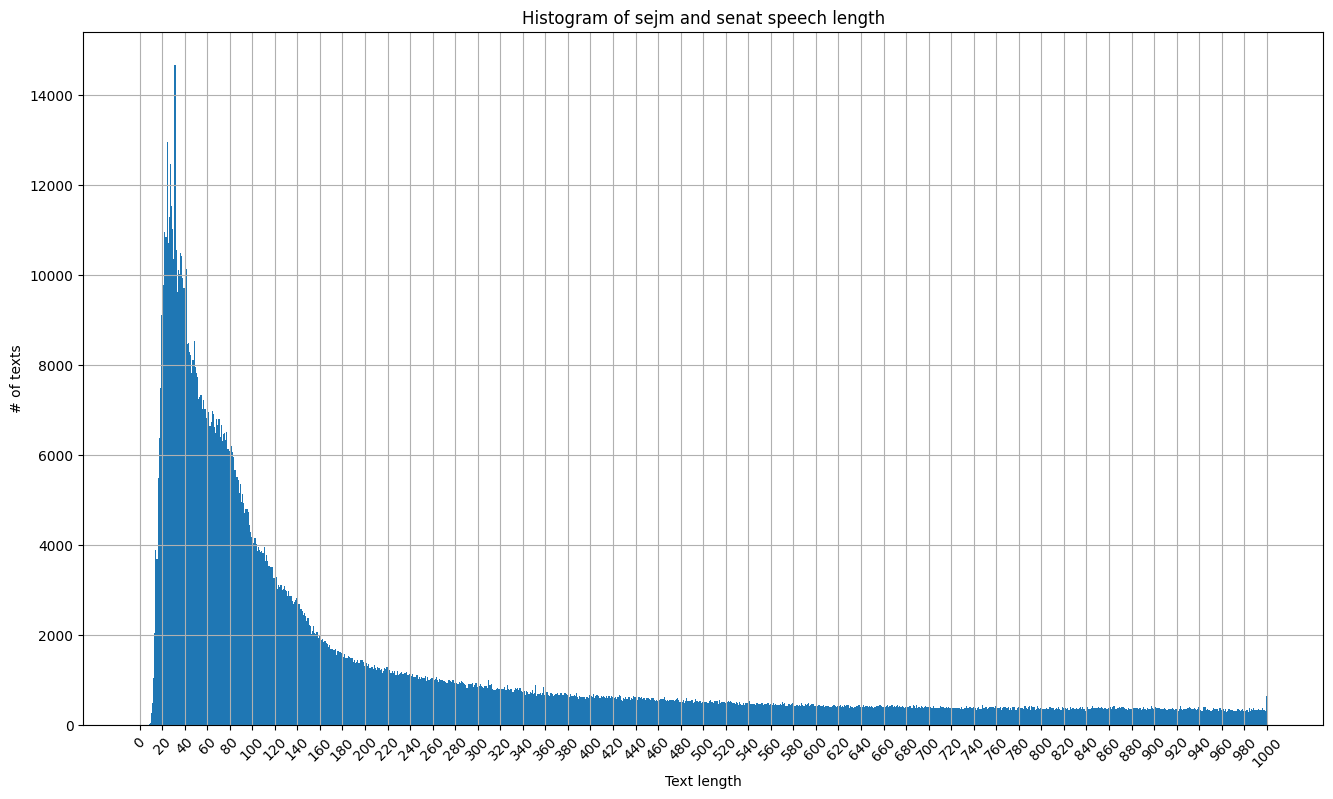

In [7]:
fig, ax = plt.subplots()
max_range=1000
df_sejm.text_all.str.len().hist(range=(0, max_range), bins=max_range, ax=ax)
ax.set_title('Histogram of sejm and senat speech length')
ax.set_ylabel('# of texts')
ax.set_xlabel('Text length')
ax.set_xticks(range(0, max_range+1, 20))
ax.set_xticklabels(range(0, max_range+1, 20), rotation=45)
fig.set_size_inches(16, 9)


In [8]:
text_all = df_sejm.text_all

def print_sample_texts_in_range(min_range = 20,max_range = 100):
    subset_of_n_length = text_all[(text_all.str.len() > min_range) & (text_all.str.len() <= max_range)]
    print(f'Sample of texts with length in range ({min_range}, {max_range}] ({len(subset_of_n_length)*100/len(text_all):.2f}%):\n')
    for text in subset_of_n_length.sample(40):
        print(text)

print_sample_texts_in_range(0, 150)
print()
print_sample_texts_in_range(100, 200)
print()
print_sample_texts_in_range(200, 1000)
print()
print_sample_texts_in_range(1000, 10000)
print()
print_sample_texts_in_range(10000, 100000)

Sample of texts with length in range (0, 150] (47.03%):

(ja mam prawo mieć inne odczucia.)
dobrze, jesteśmy w trakcie głosowania, które zarządziłem.
(członkowie nie są aktywistami, panie pośle.)
(czy mam odpowiedzieć?)
(zaraz, zaraz. o który artykuł chodzi?)
dziękuję bardzo. bardzo proszę o zabranie głosu pana senatora piotra zientarskiego.
(...dać mu szansę do następnego razu.)
czy jeszcze są jakieś pytania? nie ma. proszę pana ministra o odpowiedź.
(w trybie sprostowania.)
dziękuję, panie senatorze. bardzo proszę, panie ministrze, o udzielnie odpowiedzi.
dziękuję, panie ministrze. jeszcze pan senator dowhan chciał zadać pytanie?
dziękuję bardzo, panie pośle. pan minister chciałby wystąpić krótko w trakcie pytań. bardzo proszę, panie ministrze.
do zadania pytania zgłosił się jeszcze pan poseł andrzej romanek. bardzo proszę. czy pan poseł zrezygnował z zadania pytania? bardzo proszę.
(ha, ha, ha!)
bardzo dziękuję, pani poseł. proszę o zabranie głosu panią poseł iwonę śledzińską-katara

Obserwacje:

1. Można zauważyć, że teksty o długości do 150 znaków nie noszą informacji niemal w ogóle, na jaki temat są wygłaszane wypowiedzi i kwalifikują się do pominięcia
2. Te teksty stanowią niemal 50% całego zbioru danych


In [9]:
df_sejm.drop(df_sejm[df_sejm.text_all.str.len() <= 150].index, inplace=True)

In [28]:
df_sejm[df_sejm['date'] < pd.Timestamp('2007-11-05')] #first day of the 7th Sejm's term of office

date                                author                                           text_all  place  TextBlob_Subjectivity  TextBlob_Polarity  sentiment_herbert openai_result text_part sentiment topic
68927   1980-01-31                    sylwester zawadzki  obywatelu marszałku! wysoki sejmie! już w pier...   sejm                  0.000            0.00000                  1           NaN       NaN       NaN   NaN
68929   1980-01-31                          adam łopatka  obywatelu marszałku! wysoka izbo! jedną z naji...   sejm                  0.125           -0.15625                  1           NaN       NaN       NaN   NaN
68931   1980-01-31                           edward duda  obywatelu marszałku! wysoki sejmie! wniesiony ...   sejm                  0.000            0.00000                  1           NaN       NaN       NaN   NaN
68933   1980-01-31                     maria budzanowska  wysoki sejmie! obywatelu marszałku! projekt us...   sejm                  0.000            0.00000                  1           NaN       NaN       NaN   NaN
68935   1980-01-31  minister sprawiedliwości jerzy bafia  obywatelu marszałku! wysoka izbo! inicjatywa u...   sejm                  0.000            0.00000                  1           NaN       NaN       NaN   NaN
...            ...                                   ...                                                ...    ...                    ...                ...                ...           ...       ...       ...   ...
1537785 2007-09-14                      zbigniew trybuła  panie marszałku! panie i panowie senatorowie! ...  senat                  0.000            0.00000                  0           NaN       NaN       NaN   NaN
1537787 2007-09-14                  stanisław piotrowicz  panie marszałku! wysoka izbo! oświadczenie swo...  senat                  0.400           -0.20000                  0           NaN       NaN       NaN   NaN
1537789 2007-09-14                  stanisław piotrowicz  oświadczenie kieruję do pana zbigniewa religi,...  senat                  0.000            0.00000                  0           NaN       NaN       NaN   NaN
1537791 2007-09-14                     elżbieta rafalska  panie marszałku! swoje oświadczenie kieruję do...  senat                  0.000            0.00000                  0           NaN       NaN       NaN   NaN
1537792 2007-09-14                     bogdan borusewicz  dziękuję, pani senator. przypominam, że protok...  senat                  0.000            0.00000                  1           NaN       NaN       NaN   NaN

[331825 rows x 11 columns]

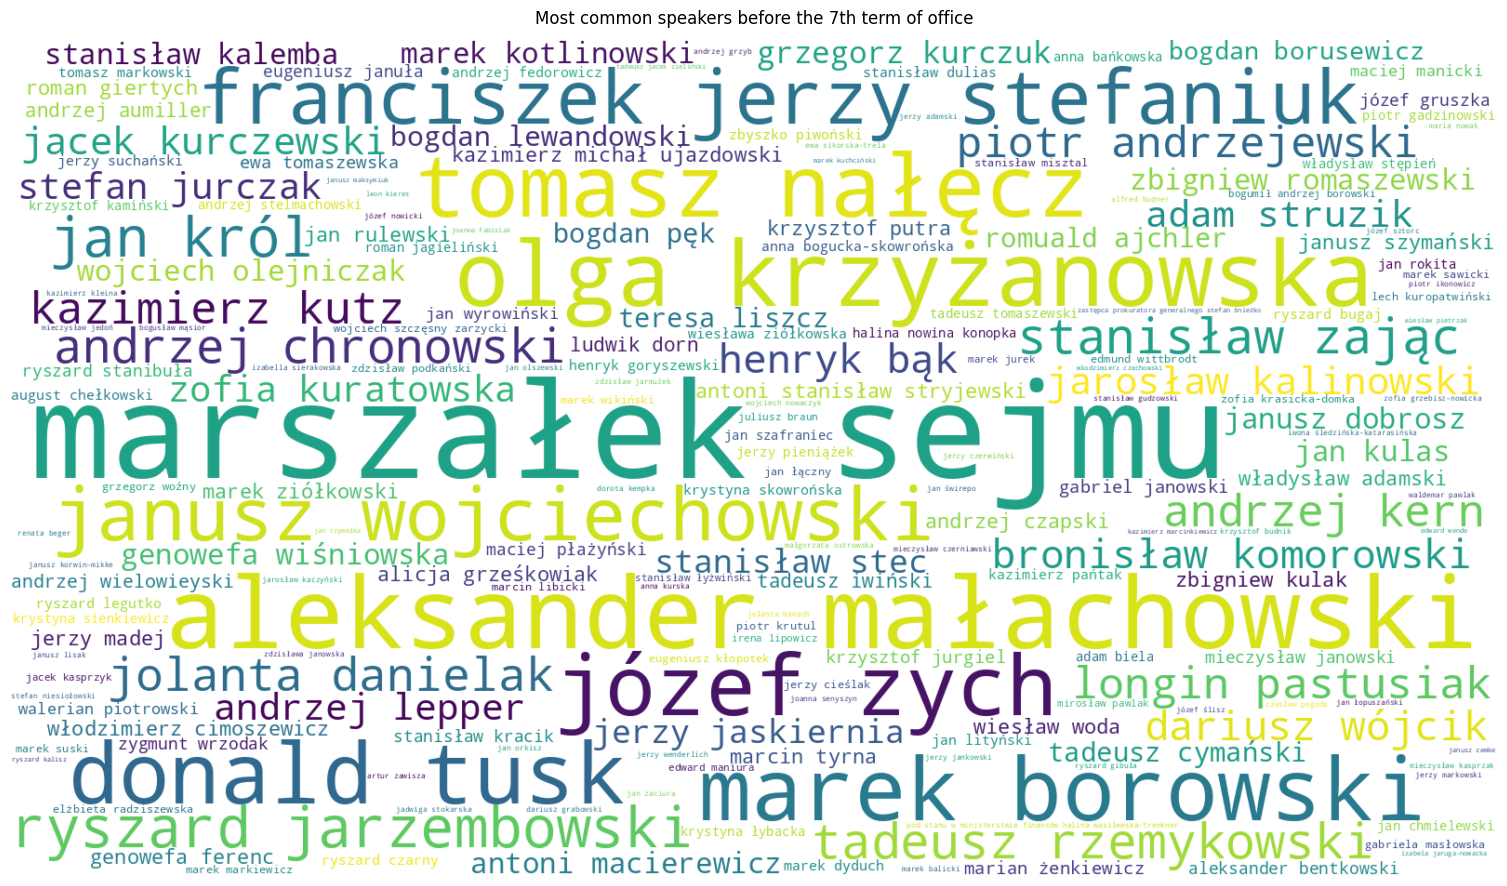

In [38]:
wc = WordCloud(width=1600, height=900, background_color='white', prefer_horizontal=1)

image = wc.generate_from_frequencies(
(df_sejm[df_sejm['date'] < pd.Timestamp('2007-11-05')].author.value_counts() / len(df_sejm[df_sejm['date'] < pd.Timestamp('2007-11-05')])).to_dict()

)

fig, ax = plt.subplots()
ax.imshow(image, interpolation='bilinear')
ax.axis('off')
fig.suptitle('Most common speakers before the 7th term of office')
fig.set_size_inches(16, 9)
fig.tight_layout()
fig.show()


# 2. Przygotowanie modelu oraz wcześniejsze zaembedowanie tekstów sejmowych dla przyspieszenia prac


In [10]:
embedding_model='paraphrase-multilingual-MiniLM-L12-v2'
sentence_model = SentenceTransformer(embedding_model, device='cuda')
if not ('embeddings' in locals()):
    if (os.path.exists('./bertopic_results/sejm/sejm_text_embeddings.npy')):
        embeddings = np.load('./bertopic_results/sejm/sejm_text_embeddings.npy')
    else:
        embeddings: np.ndarray = sentence_model.encode(df_sejm.text_all.to_numpy(), show_progress_bar=True, batch_size=128)
        np.save('./bertopic_results/sejm/sejm_text_embeddings.npy', embeddings)

In [11]:
representation_model = KeyBERTInspired(random_state=42)
calculate_probabilities = False # get document's topic probs for each detected topic, not just the predicted one
umap_model = cumlUMAP(n_neighbors=30, n_components=5, min_dist=0.0, metric='cosine', random_state=42, verbose=True)

nr_topics: int | str = 50

if not os.path.exists('./bertopic_results/sejm/model/topic_embeddings.bin'):
    topic_model = BERTopic(embedding_model=embedding_model, nr_topics=nr_topics, verbose=True, representation_model=representation_model, calculate_probabilities=calculate_probabilities, umap_model=umap_model, low_memory=True)
    topics, probs = topic_model.fit_transform(df_sejm.text_all, embeddings=embeddings)
    topic_model.save('./bertopic_results/sejm/model', serialization="pytorch", save_ctfidf=True)
else:
    topic_model = BERTopic.load('./bertopic_results/sejm/model')

# 3. Analiza wyników transformacji


In [18]:
topic_model.get_topic_info()

Topic   Count                                               Name                                     Representation  Representative_Docs
0      -1  702617                -1_komisji_posłów_powiedzieć_jednak  [komisji, posłów, powiedzieć, jednak, rząd, po...                  NaN
1       0  115935                 0_senatu_komisji_poprawce_poprawkę  [senatu, komisji, poprawce, poprawkę, senatoró...                  NaN
2       1   32432                      1_komisji_rząd_energii_trzeba  [komisji, rząd, energii, trzeba, minister, age...                  NaN
3       2    8111               2_polska_polskich_polskiej_polskiego  [polska, polskich, polskiej, polskiego, europe...                  NaN
4       3    7903         3_zdrowotnych_zdrowotnej_szpitale_szpitali  [zdrowotnych, zdrowotnej, szpitale, szpitali, ...                  NaN
5       4    7523               4_autostrady_dróg_autostrad_drogowym  [autostrady, dróg, autostrad, drogowym, drogow...                  NaN
6       5    7421                    5_środowiska_ustawa_ustawy_rząd  [środowiska, ustawa, ustawy, rząd, prawa, będą...                  NaN
7       6    5859           6_nauczycieli_szkołach_nauczyciele_szkół  [nauczycieli, szkołach, nauczyciele, szkół, na...                  NaN
8       7    4144    7_emerytalnych_emerytalnego_emerytalne_emerytów  [emerytalnych, emerytalnego, emerytalne, emery...                  NaN
9       8    2943                     8_leśnych_leśnego_lasów_leśnej  [leśnych, leśnego, lasów, leśnej, drzew, środo...                  NaN
10      9    2748    9_sądownictwa_sędziowie_sędziów_konstytucyjnego  [sądownictwa, sędziowie, sędziów, konstytucyjn...                  NaN
11     10    2201               10_rzecznika_rzecznik_dzieci_dziecka  [rzecznika, rzecznik, dzieci, dziecka, dziećmi...                  NaN
12     11    1620  11_prywatyzacji_prywatyzacja_reprywatyzacji_mi...  [prywatyzacji, prywatyzacja, reprywatyzacji, m...                  NaN
13     12    1619                    12_kobietom_kobiety_kobiet_płci  [kobietom, kobiety, kobiet, płci, dyskryminacj...                  NaN
14     13    1366    13_kościelnych_wyznaniowych_kościołów_kościołem  [kościelnych, wyznaniowych, kościołów, kościoł...                  NaN
15     14    1286                  14_sportu_sportem_sport_sportowej  [sportu, sportem, sport, sportowej, sportowy, ...                  NaN
16     15    1218  15_niepełnosprawnym_niepełnosprawnej_niepełnos...  [niepełnosprawnym, niepełnosprawnej, niepełnos...                  NaN
17     16     994            16_wojskowych_wojskowe_wojskowej_wojska  [wojskowych, wojskowe, wojskowej, wojska, wojs...                  NaN
18     17     778              17_urodzin_historii_rocznicy_rocznicę  [urodzin, historii, rocznicy, rocznicę, roczni...                  NaN
19     18     729   18_inspektorów_inspektorzy_inspektora_pracodawca  [inspektorów, inspektorzy, inspektora, pracoda...                  NaN
20     19     679  19_telekomunikacyjnej_telekomunikacji_telekomu...  [telekomunikacyjnej, telekomunikacji, telekomu...                  NaN
21     20     643        20_repatriantów_repatriacji_obywatel_ustawa  [repatriantów, repatriacji, obywatel, ustawa, ...                  NaN
22     21     490              21_azbestu_azbestowych_azbest_komisji  [azbestu, azbestowych, azbest, komisji, dyrekt...                  NaN
23     22     332               22_wiesław_michał_bogusław_władysław  [wiesław, michał, bogusław, władysław, czesław...                  NaN
24     23     328        23_instytutów_naukowej_naukowego_badawczych  [instytutów, naukowej, naukowego, badawczych, ...                  NaN
25     24     274  24_szczepionka_szczepionek_szczepionki_szczepi...  [szczepionka, szczepionek, szczepionki, szczep...                  NaN
26     25     222                     25_muzeach_muzeów_muzea_muzeum  [muzeach, muzeów, muzea, muzeum, dziedzictwa, ...                  NaN
27     26     218                   26_posłowie_kluby_po

In [19]:
topic_model.get_document_info(df_sejm.text_all)

Document  Topic                                   Name                                     Representation  Representative_Docs                                        Top_n_words  Representative_document
0       drodzy rodacy! wielce szanowny panie marszałku...     -1    -1_komisji_posłów_powiedzieć_jednak  [komisji, posłów, powiedzieć, jednak, rząd, po...                  NaN  komisji - posłów - powiedzieć - jednak - rząd ...                    False
1       bardzo dziękuję panu prezydentowi za tak istot...      0     0_senatu_komisji_poprawce_poprawkę  [senatu, komisji, poprawce, poprawkę, senatoró...                  NaN  senatu - komisji - poprawce - poprawkę - senat...                    False
2       poseł antoni macierewicz. dziękuję bardzo. pro...     -1    -1_komisji_posłów_powiedzieć_jednak  [komisji, posłów, powiedzieć, jednak, rząd, po...                  NaN  komisji - posłów - powiedzieć - jednak - rząd ...                    False
3       dziękuję. panie marszałku! wysoka izbo! panie ...     -1    -1_komisji_posłów_powiedzieć_jednak  [komisji, posłów, powiedzieć, jednak, rząd, po...                  NaN  komisji - posłów - powiedzieć - jednak - rząd ...                    False
4       bardzo dziękuję, pani poseł. zanim przejdziemy...     -1    -1_komisji_posłów_powiedzieć_jednak  [komisji, posłów, powiedzieć, jednak, rząd, po...                  NaN  komisji - posłów - powiedzieć - jednak - rząd ...                    False
...                                                   ...    ...                                    ...                                                ...                  ...                                                ...                      ...
914219  dziękuję bardzo. oświadczenie w sprawie wpisan...     -1    -1_komisji_posłów_powiedzieć_jednak  [komisji, posłów, powiedzieć, jednak, rząd, po...                  NaN  komisji - posłów - powiedzieć - jednak - rząd ...                    False
914220  panie marszałku! wysoka izbo! swoje dzisiejsze...     17  17_urodzin_historii_rocznicy_rocznicę  [urodzin, historii, rocznicy, rocznicę, roczni...                  NaN  urodzin - historii - rocznicy - rocznicę - roc...                    False
914221  kończę myśl. …a następnie o zapewnienie finans...      2   2_polska_polskich_polskiej_polskiego  [polska, polskich, polskiej, polskiego, europe...                  NaN  polska - polskich - polskiej - polskiego - eur...                    False
914222  dziękuję bardzo, panie marszałku. swoje oświad...     -1    -1_komisji_posłów_powiedzieć_jednak  [komisji, posłów, powiedzieć, jednak, rząd, po...                  NaN  komisji - posłów - powiedzieć - jednak - rząd ...                    False
914223  dziękuję bardzo, panie senatorze. więcej oświa...      0     0_senatu_komisji_poprawce_poprawkę  [senatu, komisji, poprawce, poprawkę, senatoró...                  NaN  senatu - komisji - poprawce - poprawkę - senat...                    False

[914224 rows x 7 columns]

In [20]:
print('Topics summary:')
documents_info = topic_model.get_document_info(df_sejm.text_all)
for index, line in topic_model.get_topic_info().iterrows():
    print()
    print(f'Topic:', line.Name)
    print(f"Representation:\n{line.Representation}")


    print('Texts:')
    for text in documents_info.loc[documents_info.Topic == line.Topic, 'Document'].sample(10):
        print(f"\t{text}")

Topics summary:

Topic: -1_komisji_posłów_powiedzieć_jednak
Representation:
['komisji', 'posłów', 'powiedzieć', 'jednak', 'rząd', 'poprawki', 'marszałku', 'poseł', 'było', 'przez']
Texts:
	panie marszałku! wysoki sejmie! w imieniu klubu parlamentarnego konfederacji polski niepodległej przedstawię nasze stanowisko wobec poselskiego projektu ustawy o pomocy państwa w spłacie niektórych kredytów mieszkaniowych, zwrocie bankom wypłaconych premii gwarancyjnych oraz o zmianie niektórych ustaw (druk nr 939). na wstępie chciałbym zauważyć, że pierwsza strona druku sejmowego nr 939, na której podpisani są posłowie wnioskodawcy, nosi datę 17 marca 1995 r., a następna strona, która jest zapisem projektu ustawy, nosi datę 28 marca. czy można zatem wnioskować, że posłowie podpisali coś, czego nie znali? powracam jednak do treści projektu. w uzasadnieniu napisano, że: ˝projekt omawianej ustawy w sposób kompleksowy określa formy oraz podstawowe warunki i zasady pomocy państwa w spłacie kredytów miesz

Obserwacje:

1. Niektóre tematy przypisano zgodnie z tematem sklasyfikowanym empirycznie (np. `12_weterynarii_weterynaryjnej_zwierzętami_zwierzętach`)
2. Niektóre tematy są wynikiem wykrycia pewnych szumów w danych (np. )
